In [1]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 
#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))
    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon


In [30]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
#run=20 #1/4 degree NeverWorld setup
run=26 #1/8 degree NeverWorld setup
#run=28 #1/16 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00000500.nc' % (run), decode_times=False)
tau = 500*86400
end_time = 30500
start_time = end_time - tau/86400
#sn     = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False) #snapshot
av     = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)  #5-day average
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [29]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
run=33 #1/32 degree NeverWorld setup
fs=xr.open_dataset('run%i/static.nc' % (run), decode_times=False)
os=xr.open_dataset('run%i/ocean.stats.nc' % (run), decode_times=False)
forcing=xr.open_dataset('run%i/forcing_00002000.nc' % (run), decode_times=False)
#av = xr.open_dataset('run%i/averages_00002002.nc' % (run), decode_times=False)  #5-day average

av=xr.open_mfdataset(['run33/averages_00001702.nc','run33/averages_00001802.nc', 'run33/averages_00001902.nc', 'run33/averages_00002002.nc', 'run33/averages_00002102.nc'],decode_times=False,combine='by_coords')
print(av)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/neerajab/NeverWorld2
<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 1920, xq: 1921, yh: 4480, yq: 4481, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * yq          (yq) float64 -70.0 -69.97 -69.94 -69.91 ... 69.94 69.97 70.0
  * xh          (xh) float64 0.01562 0.04688 0.07812 ... 59.92 59.95 59.98
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * xq          (xq) float64 0.0 0.03125 0.0625 0.09375 ... 59.94 59.97 60.0
  * yh          (yh) float64 -69.98 -69.95 -69.92 -69.89 ... 69.92 69.95 69.98
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 1.702e+03 1.708e+03 ... 2.192e+03 2.198e+03
Data variables:
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(20, 15, 4480, 1921), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(20, 15, 4481, 1920), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask

In [31]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']

xh = fs.xh.values
yh = fs.yh.values

taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
taux.shape

(1120, 480)

In [32]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
drhomat=np.tile(drho,[len(yh),len(xh),1]);    drhomat =np.moveaxis(drhomat, [0, 1, 2], [1,2,0])


v = (np.array(av['v'][-1,:,:,:])); v=(v[:,:-1,:]+v[:,1:,:])/2; #v=v[:,index_lat,index_lon]
u = (np.array(av['u'][-1,:,:,:])); u=(u[:,:,:-1]+u[:,:,1:])/2; 


h = np.array(av['h'][-1,:,:,:]);
eta = np.zeros([len(Layer)+1,lon.shape[0],lon.shape[1]]);

for i in range(1,len(Layer)+1):
    eta[i,:,:]=np.nansum(h[0:i,:,:],axis=0)    
#To make sure eta is correct: #print(eta[:,50]); print(h[:,50])    
eta=(eta[1:,:,:]+eta[:-1,:,:])/2.
drhodz=drhomat/h
N2=(9.81/1025.)*drhodz

#Filter out overly high N2 values (corresponding to very thin layers)
u[N2>1.e-3] =np.nan
v[N2>1.e-3] =np.nan
eta[N2>1.e-3] =np.nan
N2[N2>1.e-3] =np.nan

print(u.shape)

(15, 1120, 480)


In [33]:
len(xh)

480

In [34]:
KE=np.empty([13,len(yh),len(xh)])*np.nan
KE.shape

(13, 1120, 480)

In [39]:
# for j in range(len(xh)):
#     for i in range(len(yh)):
#         eta_local=eta[:,i,j]; u_local=u[:,i,j]; v_local=v[:,i,j]; N2_local=N2[:,i,j]
#         eta_filtered = eta_local[~np.isnan(N2_local)]
#         u_filtered = u_local[~np.isnan(N2_local)]
#         v_filtered = v_local[~np.isnan(N2_local)]
#         N2_filtered = N2_local[~np.isnan(N2_local)]
#         nmodes=len(N2_filtered)-3
#         if nmodes>=1:
#             [G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes)
#             if ~np.isnan(u_filtered*v_filtered).any(): #Only do this if no nans present:
#                 amp_u=np.linalg.lstsq(Gz,u_filtered)[0]
#                 amp_v=np.linalg.lstsq(Gz,v_filtered)[0]
#                 KE_local=0.5*(amp_u**2+amp_v**2)
#                 KE[0:len(KE_local),i,j]=KE_local           
#     print(j)

#from scipy.io import savemat
#mdic = {"KE for each mode": KE, "lon":lon,"lat":lat}
#savemat("Thirtysecond_deg_QG_modes.mat", mdic)

from scipy.io import loadmat
ds  = loadmat('Eighth_deg_QG_modes.mat')
lon = ds['lon']
lat = ds['lat']
KE  = ds['KE for each mode']
KE.shape

(13, 1120, 480)

In [40]:
KE_vertical=np.nansum(KE,axis=0)
KE_vertical.shape

(1120, 480)

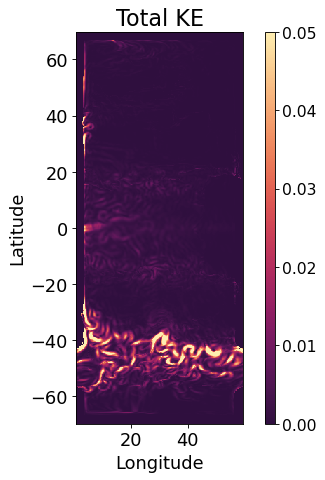

In [15]:
#Plotting total KE
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Total KE',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,KE_vertical,cmap=cmocean.cm.matter_r,vmin=0,vmax=.05)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

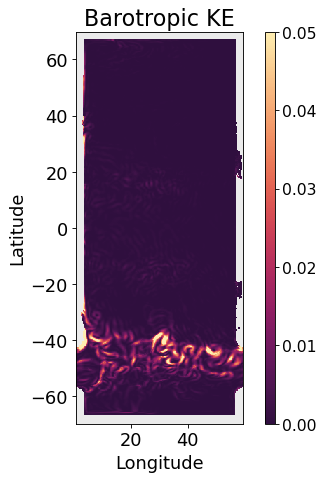

In [16]:
#Plotting Barotropic KE
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Barotropic KE',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,KE[0,:,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=.05)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

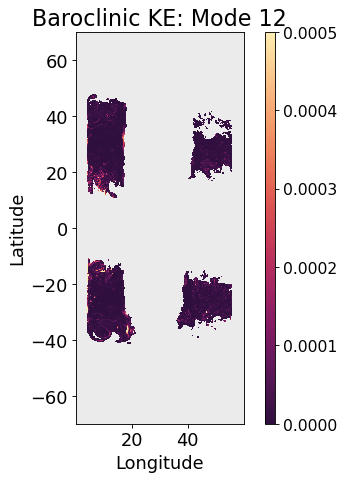

In [53]:
#Plotting Baroclinic KE
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Baroclinic KE: Mode 12',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,KE[12,:,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=.0005)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

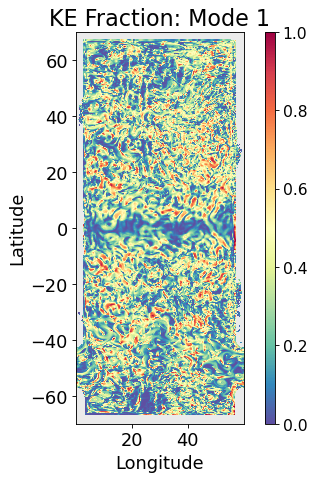

In [54]:
#Plotting Fraction of each mode
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('KE Fraction: Mode 1',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,KE[1,:,:]/KE_vertical,cmap=cm.Spectral_r,vmin=0,vmax=1.)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

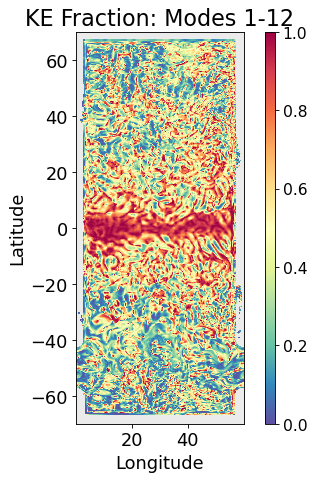

In [121]:
#Plotting Fraction of all baroclinic modes
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('KE Fraction: Modes 1-12',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,np.nansum(KE[1:,:,:],axis=0)/KE_vertical,cmap=cm.Spectral_r,vmin=0,vmax=1.)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

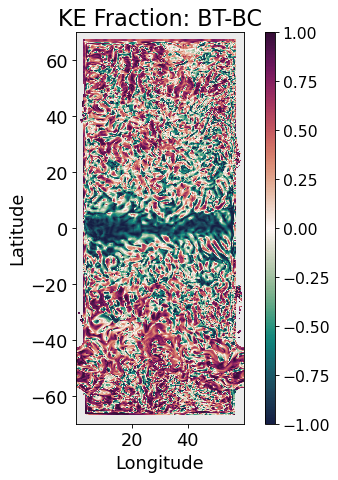

In [122]:
#Plotting Fraction of all baroclinic modes
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('KE Fraction: BT-BC',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,(KE[0,:,:])/KE_vertical-np.nansum(KE[1:,:,:],axis=0)/KE_vertical,cmap=cmocean.cm.curl,vmin=-1,vmax=1.)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()

0
1


Text(0.5, 1.0, '1/8$^\\circ$ KE fraction by mode')

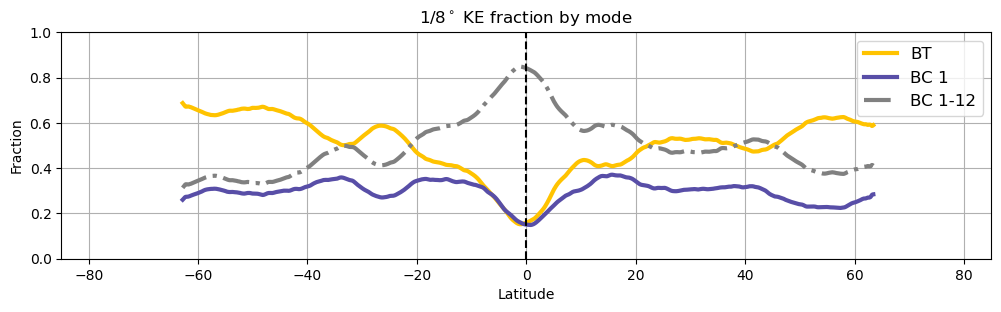

In [42]:
#For the convolution window use N=240 for 1/32 deg.; N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.
window=60

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
color=iter(['#FFC300','#584EA7','#fe2c54'])
#color=iter(['#82cafc','#fcb001','#fe2c54','#1fa774','#acfffc','#910951','#c875c4','#030aa7','#887191','#0a481e','#cb7723','#94568c','#fdff52'])
#color=iter(cm.viridis_r(np.linspace(0,1,13))) #rainbow
#plt.style.use('default')
for i in range(2):
    print(i)
    c=next(color)
    KE_fraction=KE[i,:,:]/KE_vertical
    plt.plot(yh,np.convolve(np.nanmean(KE_fraction,axis=1), np.ones((window,))/window, mode='same'),'-',c=c,linewidth=3)
plt.grid()
BCsum=np.nansum(KE[1:,:,:],axis=0)/KE_vertical
plt.plot(yh,np.convolve(np.nanmean(BCsum,axis=1), np.ones((window,))/window, mode='same'),'-.',c=[0.5, 0.5, 0.5],linewidth=3)

plt.legend(['BT','BC 1','BC 1-12'],loc='upper right',fontsize=12)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1)
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/8$^\circ$ KE fraction by mode')

0
1
2
3
4
5
6
7
8
9
10
11
12


Text(0.5, 1.0, '1/16$^\\circ$ KE fraction by mode')

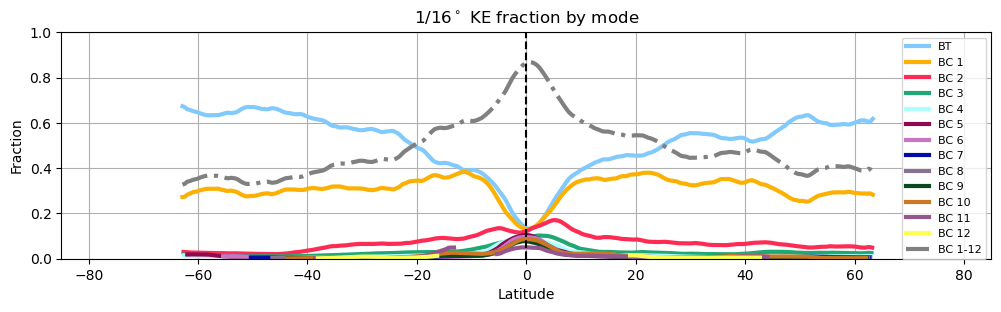

In [51]:
#For the convolution window use N=120 for 1/16deg.; N=60 for 1/8deg.; and N=30 for 1/4deg.

plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
color=iter(['#82cafc','#fcb001','#fe2c54','#1fa774','#acfffc','#910951','#c875c4','#030aa7','#887191','#0a481e','#cb7723','#94568c','#fdff52'])
#color=iter(cm.viridis_r(np.linspace(0,1,13))) #rainbow
#plt.style.use('default')
for i in range(13):
    print(i)
    c=next(color)
    KE_fraction=KE[i,:,:]/KE_vertical
    plt.plot(yh,np.convolve(np.nanmean(KE_fraction,axis=1), np.ones((120,))/120, mode='same'),'-',c=c,linewidth=3)
plt.grid()
BCsum=np.nansum(KE[1:,:,:],axis=0)/KE_vertical
plt.plot(yh,np.convolve(np.nanmean(BCsum,axis=1), np.ones((120,))/120, mode='same'),'-.',c=[0.5, 0.5, 0.5],linewidth=3)

plt.legend(['BT','BC 1','BC 2','BC 3','BC 4','BC 5','BC 6','BC 7','BC 8','BC 9','BC 10','BC 11','BC 12', 'BC 1-12'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/16$^\circ$ KE fraction by mode')

0
1
2
3
4
5
6
7
8
9
10
11
12


Text(0.5, 1.0, '1/4$^\\circ$ KE fraction by mode')

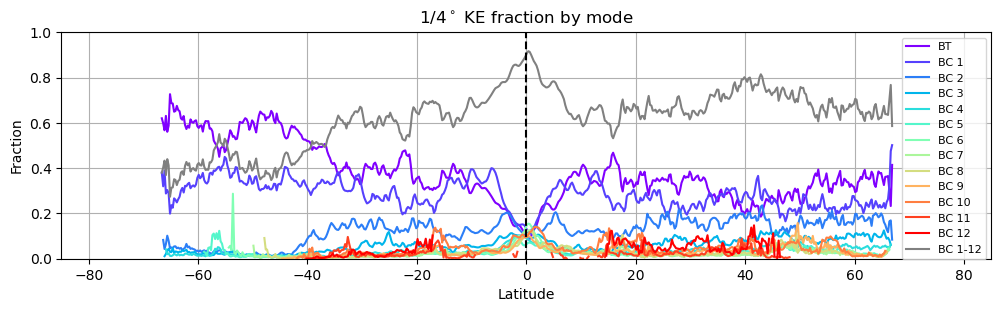

In [13]:
plt.figure(figsize=(12, 3), dpi= 100, facecolor='w', edgecolor='k')
color=iter(cm.rainbow(np.linspace(0,1,13))) #rainbow
#plt.style.use('default')
for i in range(13):
    print(i)
    c=next(color)
    KE_fraction=KE[i,:,:]/KE_vertical
    plt.plot(yh,np.nanmean(KE_fraction,axis=1),'-',c=c)
plt.grid()
BCsum=np.nansum(KE[1:,:,:],axis=0)/KE_vertical
plt.plot(yh,np.nanmean(BCsum,axis=1),'-',c=[0.5, 0.5, 0.5])

plt.legend(['BT','BC 1','BC 2','BC 3','BC 4','BC 5','BC 6','BC 7','BC 8','BC 9','BC 10','BC 11','BC 12', 'BC 1-12'],loc='upper right',fontsize=8)
plt.plot([0, 0],[0, 1],'--',color=[0,0,0])
plt.xlim(-85, 85)
plt.ylim(0,1);
plt.xlabel('Latitude')
plt.ylabel('Fraction')
plt.title('1/4$^\circ$ KE fraction by mode')